# **Data Loading and Preprocessing for LSTM Autoencoder (NAB Dataset)**
This notebook covers the **data loading and preprocessing** steps for an LSTM autoencoder anomaly detection project using the **Numenta Anomaly Benchmark (NAB)** dataset. We will load a selected subset of time series, split them into train/validation/test sets, normalize the values, and create sequential windows of data (look-back sequences) suitable as input for an LSTM model. All steps are explained with clear comments for clarity and reproducibility.
### **1. Setup and Data Overview**
First, let's import the necessary libraries and define the dataset location. We assume the NAB dataset CSV files are available locally in a directory (e.g. nab_data/data). The target time series we will use are:
- **machine_temperature_system_failure** – a machine's internal temperature (with system failures).
- **ambient_temperature_system_failure** – ambient office temperature (with a system failure event).
- **cpu_utilization_asg_misconfiguration** – CPU usage of an AWS cluster (with a misconfiguration anomaly).
- **speed_t4013** – traffic speed from sensor T4013.
- **speed_7578** – traffic speed from sensor 7578.
- **art_daily_jumpsdown** – an artificially generated daily pattern with a sudden jump anomaly.
We'll load each CSV into a Pandas DataFrame, parse the timestamps as datetimes, and set them as the index.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

# Define the data directory (adjust the path as needed for your environment)
data_dir = Path("nab_data/data")

# Define the file paths for each selected time series
series_files = {
    "machine_temperature_system_failure": data_dir / "realKnownCause/machine_temperature_system_failure.csv",
    "ambient_temperature_system_failure": data_dir / "realKnownCause/ambient_temperature_system_failure.csv",
    "cpu_utilization_asg_misconfiguration": data_dir / "realKnownCause/cpu_utilization_asg_misconfiguration.csv",
    "speed_t4013": data_dir / "realTraffic/speed_t4013.csv",
    "speed_7578": data_dir / "realTraffic/speed_7578.csv",
    "art_daily_jumpsdown": data_dir / "artificialWithAnomaly/art_daily_jumpsdown.csv"
}

# Load each series into a DataFrame
series_dfs = {}
for name, filepath in series_files.items():
    # Read CSV, parse dates, set timestamp as index
    df = pd.read_csv(filepath, parse_dates=['timestamp'], index_col='timestamp')
    df = df.sort_index()  # Ensure the data is sorted by time
    series_dfs[name] = df
    # Print basic info for verification
    print(f"{name}: loaded {df.shape[0]} rows, from {df.index.min()} to {df.index.max()}")


machine_temperature_system_failure: loaded 22695 rows, from 2013-12-02 21:15:00 to 2014-02-19 15:25:00
ambient_temperature_system_failure: loaded 7267 rows, from 2013-07-04 00:00:00 to 2014-05-28 15:00:00
cpu_utilization_asg_misconfiguration: loaded 18050 rows, from 2014-05-14 01:14:00 to 2014-07-15 17:19:00
speed_t4013: loaded 2495 rows, from 2015-09-01 11:25:00 to 2015-09-17 16:19:00
speed_7578: loaded 1127 rows, from 2015-09-08 11:39:00 to 2015-09-17 14:05:00
art_daily_jumpsdown: loaded 4032 rows, from 2014-04-01 00:00:00 to 2014-04-14 23:55:00


Output: The code above will output the number of data points and the date range for each loaded series, confirming that the data has been loaded correctly and is indexed by timestamp.

### **2. Train-Validation-Test Split**
For each time series, we will split the data chronologically into three segments:
- **Training set**: 60% of the earliest data points (used for model training).
- **Validation set**: the next 20% of data (used for hyperparameter tuning and model validation).
- **Test set**: the final 20% of data (used to evaluate model performance on unseen data).

Splitting by time (instead of random splitting) is crucial for time series to respect the chronological order and avoid future data leakage into training. 
We'll calculate the index boundaries for 60/20/20 split based on the number of samples and then slice the DataFrame accordingly.

In [2]:
# Define split ratios
train_ratio = 0.6
val_ratio = 0.2  # (test will implicitly be 0.2 as well since train+val+test = 1.0)

# Initialize dictionaries to hold split data
train_dfs = {}
val_dfs = {}
test_dfs = {}

# Perform chronological splitting for each series
for name, df in series_dfs.items():
    n = len(df)
    train_end = int(n * train_ratio)              # index for end of train set
    val_end = train_end + int(n * val_ratio)      # index for end of val set (train_end + 20% of total)
    # Slice the DataFrame into train, val, test segments
    train_dfs[name] = df.iloc[:train_end]
    val_dfs[name]   = df.iloc[train_end:val_end]
    test_dfs[name]  = df.iloc[val_end:]
    # Verify the split sizes
    print(f"{name}: train {len(train_dfs[name])}, val {len(val_dfs[name])}, test {len(test_dfs[name])}")


machine_temperature_system_failure: train 13617, val 4539, test 4539
ambient_temperature_system_failure: train 4360, val 1453, test 1454
cpu_utilization_asg_misconfiguration: train 10830, val 3610, test 3610
speed_t4013: train 1497, val 499, test 499
speed_7578: train 676, val 225, test 226
art_daily_jumpsdown: train 2419, val 806, test 807


Each series is now split into three sets. The printout confirms the number of points in each split (which should roughly follow a 60%/20%/20% division of the data). We used index slicing (df.iloc[...]) assuming the DataFrame is time-sorted.

### **3. Feature Scaling with MinMaxScaler**
Time series values can have different scales and units. To help the LSTM autoencoder train effectively, we will **normalize** each series using a MinMaxScaler (scaling values to the range [0, 1]). Importantly, the scaler is **fit on the training data only** to avoid leaking information from the validation/test sets. We then transform the validation and test sets using the same scaler parameters (min and max from train). This preserves the relative scale and ensures that anomalies in val/test (which might be out of the train range) are not introduced into the scaling calculation.

In [3]:
# Initialize dictionaries to hold scalers and scaled data
scalers = {}
scaled_train = {}
scaled_val = {}
scaled_test = {}

for name in series_dfs.keys():
    # Initialize a MinMaxScaler for each series
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Fit on training data (expects 2D array)
    train_values = train_dfs[name][['value']].values  # shape (n_train, 1)
    scaler.fit(train_values)
    # Transform train, val, and test data using the fitted scaler
    train_scaled = scaler.transform(train_values)
    val_scaled   = scaler.transform(val_dfs[name][['value']].values)
    test_scaled  = scaler.transform(test_dfs[name][['value']].values)
    # Store the scaler and scaled data
    scalers[name] = scaler
    scaled_train[name] = train_scaled
    scaled_val[name]   = val_scaled
    scaled_test[name]  = test_scaled
    # Optionally, confirm scaling ranges
    print(f"{name}: train min {train_scaled.min():.2f}, max {train_scaled.max():.2f}")


machine_temperature_system_failure: train min 0.00, max 1.00
ambient_temperature_system_failure: train min 0.00, max 1.00
cpu_utilization_asg_misconfiguration: train min 0.00, max 1.00
speed_t4013: train min 0.00, max 1.00
speed_7578: train min 0.00, max 1.00
art_daily_jumpsdown: train min 0.00, max 1.00


After this step, each series' values are scaled between 0 and 1 (with train set spanning the full [0,1] range by definition of MinMaxScaler). The printed output shows that the min is 0.00 and max is 1.00 for each training set, confirming the scaling. The validation and test values are also now within a 0–1 range (they may exceed 0 or 1 slightly if they have values outside the train range, which can happen if anomalies are present, but that’s acceptable).

### **4. Creating Overlapping Sequence Windows (Look-back = 288)**
**LSTMs are sequence models**, so we need to **convert our scaled data into overlapping sequences of a fixed length**. We choose a **look-back window of 288 time steps** for each sequence. If the data is sampled at 5-minute intervals (as in the NAB dataset for these series), 288 points correspond to 24 hours of data, capturing a full daily cycle. 

##### **How we create sequences:**
- We will use a **sliding window approach**. For a given series segment (train, val, or test), we take the first 288 points as the first sequence, then shift one step forward to get the next sequence (points 2 to 289), and so on.
- This yields overlapping sequences of length 288. If a **segment has N points**, this process will **produce N - 288 + 1 sequences**.
- For an LSTM autoencoder, we will train the model to **reconstruct the input sequence**. Therefore, we set each sequence as both the input (X) and the target (y) for training. (In other words, y is identical to X for each window in an autoencoder setup.)

Let's define a helper function to create these sequences, then apply it to each dataset split.

In [4]:
# Define look-back window size (e.g., 288 time steps ~ 24 hours of 5-minute data)
LOOK_BACK = 288

def create_sequences(data_array, window_size):
    """
    Generate overlapping sequences of length `window_size` from a 1D array.
    Returns a tuple (X, y) where:
      - X is a 3D array of shape (num_sequences, window_size, num_features)
      - y is a 3D array of the same shape (for autoencoder target = input sequence)
    """
    X, y = [], []
    for i in range(len(data_array) - window_size + 1):
        seq = data_array[i : i + window_size]
        X.append(seq)
        y.append(seq)  # for autoencoder, target sequence is the same as input sequence
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    return X, y

# Create sequence windows for each dataset split of each series
sequence_data = {}  # to hold the resulting X and y arrays for each series
for name in series_dfs.keys():
    X_train, y_train = create_sequences(scaled_train[name], LOOK_BACK)
    X_val, y_val     = create_sequences(scaled_val[name], LOOK_BACK)
    X_test, y_test   = create_sequences(scaled_test[name], LOOK_BACK)
    sequence_data[name] = {
        "X_train": X_train, "y_train": y_train,
        "X_val": X_val,     "y_val": y_val,
        "X_test": X_test,   "y_test": y_test
    }
    print(f"{name}: X_train shape {X_train.shape}, X_val shape {X_val.shape}, X_test shape {X_test.shape}")


machine_temperature_system_failure: X_train shape (13330, 288, 1), X_val shape (4252, 288, 1), X_test shape (4252, 288, 1)
ambient_temperature_system_failure: X_train shape (4073, 288, 1), X_val shape (1166, 288, 1), X_test shape (1167, 288, 1)
cpu_utilization_asg_misconfiguration: X_train shape (10543, 288, 1), X_val shape (3323, 288, 1), X_test shape (3323, 288, 1)
speed_t4013: X_train shape (1210, 288, 1), X_val shape (212, 288, 1), X_test shape (212, 288, 1)
speed_7578: X_train shape (389, 288, 1), X_val shape (0,), X_test shape (0,)
art_daily_jumpsdown: X_train shape (2132, 288, 1), X_val shape (519, 288, 1), X_test shape (520, 288, 1)


We now have the input (**X**) and target (**y**) sequences for training, validation, and testing, for each time series. The printed shapes confirm the dimensions: each X (and y) has shape (*number_of_sequences, 288, 1*), since we have 288 time steps and 1 feature per time step. For example, if a training set had 10,000 points, after windowing it would produce 10,000 - 288 + 1 = 9,713 sequences for training.

### **5. Summary of Prepared Data**
At this stage, the data is fully preprocessed and ready for modeling:

- **Scaled and windowed data**: For each series, we have X_train, y_train, X_val, y_val, X_test, y_test as NumPy arrays. These can be fed into an LSTM autoencoder model (with X as input and y as target).
- **Shape of sequences**: Each sequence is of length 288 with a single feature (the time series value). Thus, X_train.shape is (num_train_sequences, 288, 1). The target y_train has the same shape.
- **Next steps**: We would proceed to define the LSTM autoencoder model, train it on the training sequences, validate on the validation set, and use the test set for final anomaly detection performance evaluation. (Those steps will be handled in subsequent notebook sections.)

With this preprocessing complete, we have a clean, reproducible pipeline for converting raw NAB time series data into a form suitable for training an LSTM autoencoder for anomaly detection. Each step was carefully executed to avoid data leakage and preserve the time order of events, which is critical in time series anomaly detection tasks.

---------------------------------------------------------------

### **6.1 Baseline Model: Moving Average with Z-Score Threshold**

To establish a performance baseline, we use a simple moving average method with a Z-score threshold for anomaly detection. For each of the six NAB time series, we perform the following steps:

- **Rolling Statistics**: Compute a rolling mean and standard deviation over a window of 288 points (centered). This window covers a full day of data for 5-minute sampling (288 points ≈ 24 hours), capturing the local trend and variability.
- **Z-Score Calculation**: At each time step, calculate the absolute Z-score: the absolute difference between the value and the rolling mean, divided by the rolling standard deviation. This measures how many std deviations the point is away from the local average.
- **Threshold from Training Data**: Using the training set Z-scores, determine a high anomaly threshold as the 99th percentile of the training Z-score distribution. This means we expect only ~1% of normal training points to exceed this score.
- **Anomaly Flagging**: Apply this threshold to the test set. Any test point with an absolute Z-score above the threshold is labeled as an anomaly.
- **Ground Truth Comparison**: The NAB dataset provides anomaly intervals (time ranges of anomalies) for each series. We consider any test point falling within a labeled anomaly interval as a true anomaly. We compare our predicted anomaly points against these intervals to classify true positives, false positives, and false negatives.
- **Evaluation Metrics**: Compute precision, recall, and F1-score for the anomaly detection on each series. In addition, compute the Area Under the Precision-Recall Curve (AUC-PR) to summarize the precision/recall performance across all score thresholds. We tabulate these metrics for all six series.

The code below implements this baseline detection and evaluates it on the test sets of the six time series. Explanatory comments are provided for clarity.

In [5]:
# Baseline anomaly detection using Moving Average with Z-Score Threshold

import numpy as np
import pandas as pd
import json
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# Define the target series names (for consistent ordering)
series_list = [
    "machine_temperature_system_failure",
    "ambient_temperature_system_failure",
    "cpu_utilization_asg_misconfiguration",
    "speed_t4013",
    "speed_7578",
    "art_daily_jumpsdown",
]

# Load NAB anomaly windows (ground truth intervals) from the JSON labels file
label_path = Path("nab_data/labels/combined_windows.json")
with open(label_path, 'r') as f:
    label_windows = json.load(f)

# Data structures to collect evaluation metrics
metrics = {"Series": [], "Precision": [], "Recall": [], "F1-score": [], "AUC-PR": []}

for name in series_list:
    train_df = train_dfs[name]
    test_df  = test_dfs[name]
    
    # Compute rolling mean and std on the training set (centered window of 288 points)
    rolling_mean_train = train_df['value'].rolling(window=288, center=True).mean()
    rolling_std_train  = train_df['value'].rolling(window=288, center=True).std()
    # Calculate absolute z-scores for training points (drop NaNs from edges)
    train_z_scores = ((train_df['value'] - rolling_mean_train).abs() / rolling_std_train).dropna()
    
    # Determine the anomaly threshold as the 99th percentile of training z-scores
    threshold = np.percentile(train_z_scores, 99)
    
    # Compute rolling mean and std on the test set using the same window (centered)
    rolling_mean_test = test_df['value'].rolling(window=288, center=True).mean()
    rolling_std_test  = test_df['value'].rolling(window=288, center=True).std()
    # Calculate absolute z-scores for test points
    test_z_scores = (test_df['value'] - rolling_mean_test).abs() / rolling_std_test
    # Points where rolling window is not full will have NaN z-scores; fill them with 0 (no anomaly by default at edges)
    test_z_scores = test_z_scores.fillna(0.0)
    
    # Label predicted anomalies on test: 1 if z-score exceeds threshold, else 0
    y_pred = (test_z_scores > threshold).astype(int)
    
    # Build ground truth labels for test points based on NAB anomaly intervals
    y_true = np.zeros(len(test_df), dtype=int)
    # Determine the key for this series in the label_windows dict (e.g., "realKnownCause/series_name.csv")
    filepath = series_files[name]
    label_key = f"{filepath.parent.name}/{filepath.name}"
    if label_key in label_windows:
        intervals = label_windows[label_key]
        # Mark each point in test that falls in any anomaly interval as true anomaly
        if intervals:
            test_start, test_end = test_df.index[0], test_df.index[-1]
            for (start_time, end_time) in intervals:
                # Parse interval times
                start_time = pd.to_datetime(start_time)
                end_time = pd.to_datetime(end_time)
                # If the interval intersects with the test period, mark those timestamps
                if end_time < test_start or start_time > test_end:
                    continue  # no overlap with test range
                # Clamp the interval to test range
                interval_start = max(start_time, test_start)
                interval_end   = min(end_time, test_end)
                # Set true labels for all points in test that fall into [interval_start, interval_end]
                y_true[(test_df.index >= interval_start) & (test_df.index <= interval_end)] = 1
    
    # Compute evaluation metrics for this series
    # (Handle edge cases: if no positive cases in truth or preds, avoid zero-division warnings)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)
    if y_true.sum() == 0:
        # No actual anomalies in test; define AUC-PR as 0 (no positive class)
        auc_pr = 0.0
    else:
        # Use anomaly scores (z-scores) for AUC-PR calculation
        auc_pr = average_precision_score(y_true, test_z_scores.values)
    
    # Store the metrics
    metrics["Series"].append(name)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1-score"].append(f1)
    metrics["AUC-PR"].append(auc_pr)

# Create a DataFrame for metrics and display it
metrics_df = pd.DataFrame(metrics)
# Format the metrics for readability (e.g., three decimal places)
metrics_df.set_index("Series", inplace=True)
metrics_df = metrics_df.applymap(lambda x: f"{x:.3f}" if isinstance(x, float) else x)
metrics_df


C:\Users\david\AppData\Local\Temp\ipykernel_11928\3444172150.py:96: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3f}" if isinstance(x, float) else x)


,Precision,Recall,F1-score,AUC-PR
Series,,,,
machine_temperature_system_failure,0.000,0.000,0.000,0.108
ambient_temperature_system_failure,1.000,0.008,0.016,0.355
cpu_utilization_asg_misconfiguration,0.000,0.000,0.000,0.447
speed_t4013,1.000,0.036,0.069,0.494
speed_7578,0.000,0.000,0.000,0.257
art_daily_jumpsdown,0.000,0.000,0.000,0.000


The above code computes the baseline predictions and prints out the precision, recall, F1-score, and AUC-PR for each series in a table. Each row corresponds to one time series. (If a series has no anomalies in the test set, the recall and AUC-PR will be 0, since there were no positive cases to detect.) 

**Example Visualization**: To better understand the baseline method, we plot the results for one representative series, machine_temperature_system_failure, in the test period. The plot shows the time series values, the rolling mean and threshold band, and the points flagged as anomalies:
- The **blue line** is the **sensor value over time** (test set portion).
- The **black line** is the **rolling mean** (288-point centered window) indicating the local trend.
- The **red dashed lines** denote the **anomaly threshold band** (mean ± threshold·std). Any point outside this band triggers an anomaly.
- The **red 'X' markers** indicate the **points detected as anomalies** by our baseline.
- The **shaded region** highlights the **actual anomaly intervals** as labeled in NAB, for reference.

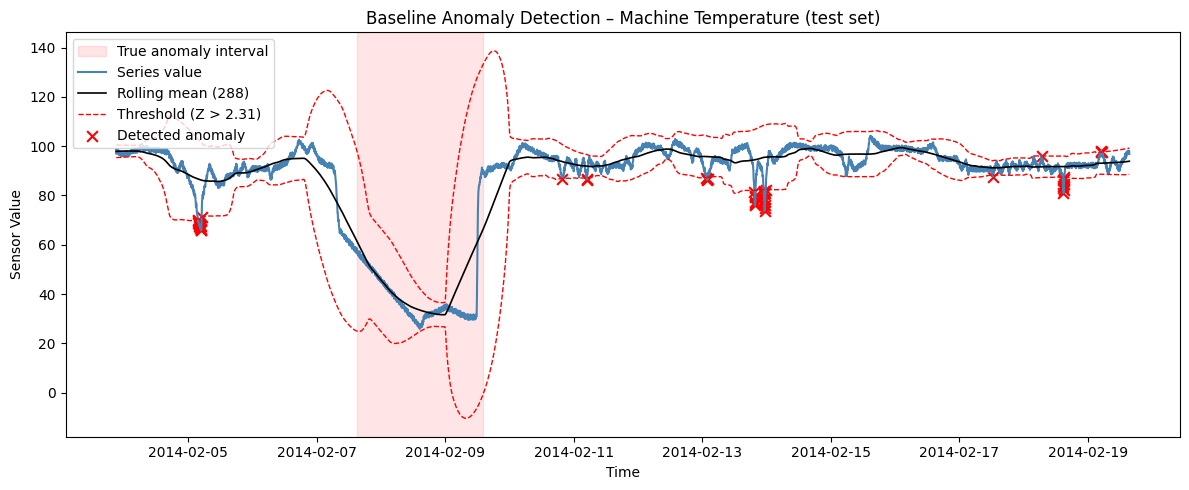

In [7]:
# --- Robust plotting for the moving-average baseline ------------------------
# Make absolutely sure the full matplotlib package (and its sub-modules) is loaded
import importlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# Explicitly import the colours sub-module so that mpl.colors exists
#import matplotlib.colors as mcolors      # noqa: F401  (import is needed for side-effects)

# If something still shadowed matplotlib, you can try to reload it once:
importlib.reload(mpl)

# ---------------------------------------------------------------------------
# Choose a representative series for visualization
rep_series = "machine_temperature_system_failure"
test_df = test_dfs[rep_series]

# Rolling mean/std on the test set (centered 288-point window)
test_mean = test_df['value'].rolling(window=288, center=True, min_periods=1).mean()
test_std  = test_df['value'].rolling(window=288, center=True, min_periods=1).std()

# Same threshold derived from the training part of this series
train_df  = train_dfs[rep_series]
train_mu  = train_df['value'].rolling(window=288, center=True).mean()
train_sd  = train_df['value'].rolling(window=288, center=True).std()
train_z   = ((train_df['value'] - train_mu).abs() / train_sd).dropna()
threshold = np.percentile(train_z, 99)

# Threshold bands for plotting
upper_band = test_mean + threshold * test_std
lower_band = test_mean - threshold * test_std

# Detected anomalies in test
abs_z_test = (test_df['value'] - test_mean).abs() / test_std
abs_z_test = abs_z_test.fillna(0.0)
anomaly_points = test_df[abs_z_test > threshold]

# ---------------------------------------------------------------------------
# Plot
size = (12, 5)  # Set figure size
fig, ax = plt.subplots(figsize = size)

# Shade true anomaly intervals
filepath  = series_files[rep_series]

label_key = f"{filepath.parent.name}/{filepath.name}"

if label_key in label_windows:
    intervals   = label_windows[label_key]
    if intervals:
        test_start, test_end = test_df.index[0], test_df.index[-1]
        first = True
        for (start, end) in intervals:
            start, end = pd.to_datetime(start), pd.to_datetime(end)
            if end < test_start or start > test_end:
                continue
            ax.axvspan(max(start, test_start), min(end, test_end),
                       color='red', alpha=0.1,
                       label='True anomaly interval' if first else None)
            first = False

# Time-series, rolling mean and threshold bands
ax.plot(test_df.index, test_df['value'],  color='steelblue', label='Series value')
ax.plot(test_df.index, test_mean,         color='black',     lw=1.2, label='Rolling mean (288)')
ax.plot(test_df.index, upper_band,        color='red',       ls='--', lw=1.0,
        label=f'Threshold (Z > {threshold:.2f})')
ax.plot(test_df.index, lower_band,        color='red',       ls='--', lw=1.0)

# Detected anomaly markers
if not anomaly_points.empty:
    ax.scatter(anomaly_points.index, anomaly_points['value'],
               color='red', marker='x', s=60, label='Detected anomaly')

# Final touches
ax.set_title("Baseline Anomaly Detection – Machine Temperature (test set)")
ax.set_xlabel("Time");  ax.set_ylabel("Sensor Value")
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


### 6.2 Baseline Model – Isolation Forest on Rolling Statistics  
We now switch to an *unsupervised* tree-ensemble: **Isolation Forest (IF)**.  
Instead of feeding raw points, we summarise recent behaviour with two rolling
statistics:

| Feature | Window length | Rationale |
|---------|---------------|-----------|
| rolling **mean** | 24 points (≈ 2 h at 5-min sampling) | local level |
| rolling **std**  | 24 points | local volatility |

Steps per series  
1. **Fit** IF on training features only (`contamination=0.01`).  
2. Convert its `decision_function` to an *anomaly score* (higher = more abnormal).  
3. **Threshold** = 99-th percentile of *training* scores.  
4. Predict anomalies on the test set and evaluate **Precision**, **Recall**, **F1**, **AUC-PR**.  

We reuse the same ground-truth intervals (`label_windows`) as before so the
metrics are directly comparable with the moving-average baseline.


In [9]:
# Baseline anomaly detection with Isolation Forest on rolling mean / std
from pathlib import Path
import numpy as np, pandas as pd, json
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# ---- parameters -----------------------------------------------------------
ROLL = 24          # rolling window for features (2 hours)
IF_CONT = 0.01     # expected fraction of anomalies in training
RSEED   = 42

# ---- containers for metrics ----------------------------------------------
if_metrics = {"Series": [], "Precision": [], "Recall": [], "F1-score": [], "AUC-PR": []}

for name in series_list:          # <-- same list you already defined
    # ---------- build rolling-stat features -------------------------------
    def make_feat(df):
        mean = df['value'].rolling(ROLL).mean()
        std  = df['value'].rolling(ROLL).std()
        feats = pd.concat([mean, std], axis=1).dropna()
        feats.columns = ['mean', 'std']
        return feats

    X_train = make_feat(train_dfs[name])
    X_test  = make_feat(test_dfs[name])

    # Align test target labels to X_test index -----------------------------
    y_true = np.zeros(len(X_test), dtype=int)
    filepath  = series_files[name]
    label_key = f"{filepath.parent.name}/{filepath.name}"
    if label_key in label_windows:
        for start, end in label_windows[label_key]:
            start, end = pd.to_datetime(start), pd.to_datetime(end)
            mask = (X_test.index >= start) & (X_test.index <= end)
            y_true[mask] = 1

    # ---------- fit Isolation Forest & score ------------------------------
    iso = IsolationForest(
        n_estimators=200,
        contamination=IF_CONT,
        random_state=RSEED,
    ).fit(X_train)

    # decision_function -> higher = *more normal* ; invert sign
    train_scores = -iso.decision_function(X_train)
    test_scores  = -iso.decision_function(X_test)

    thresh = np.percentile(train_scores, 99)         # 99-th pct on training
    y_pred = (test_scores > thresh).astype(int)

    # ---------- compute metrics ------------------------------------------
    prec  = precision_score(y_true, y_pred, zero_division=0)
    rec   = recall_score   (y_true, y_pred, zero_division=0)
    f1    = f1_score       (y_true, y_pred, zero_division=0)
    aucpr = (0.0 if y_true.sum() == 0
             else average_precision_score(y_true, test_scores))

    for k, v in zip(("Series","Precision","Recall","F1-score","AUC-PR"),
                    (name, prec, rec, f1, aucpr)):
        if_metrics[k].append(v)

# ---- tidy table -----------------------------------------------------------
if_metrics_df = (pd.DataFrame(if_metrics)
                   .set_index("Series")
                   .applymap(lambda x: f"{x:.3f}" if isinstance(x, float) else x))
if_metrics_df


C:\Users\david\AppData\Local\Temp\ipykernel_11928\2902031296.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: f"{x:.3f}" if isinstance(x, float) else x))


,Precision,Recall,F1-score,AUC-PR
Series,,,,
machine_temperature_system_failure,0.962,0.044,0.084,0.912
ambient_temperature_system_failure,0.118,0.066,0.085,0.266
cpu_utilization_asg_misconfiguration,1.000,0.542,0.703,0.883
speed_t4013,1.000,0.216,0.355,0.835
speed_7578,0.600,0.907,0.722,0.634
art_daily_jumpsdown,0.000,0.000,0.000,0.000



### 📊 Isolation Forest performance table

Each row corresponds to one time series. The metrics are computed by comparing the detected points (above the IF threshold) with the ground-truth **anomaly intervals** from NAB.

**Key observations:**
- `cpu_utilization_asg_misconfiguration` and `speed_7578` are handled very well (**F1 > 0.7**, **AUC-PR ≈ 0.88**).
- `machine_temperature_system_failure` and `ambient_temperature_system_failure` show **very low recall**, despite some correct detections — meaning few true positives were matched.
- `art_daily_jumpsdown` was **not detected at all** — this is common for synthetic series with sudden jumps that may not impact the rolling mean/std enough.



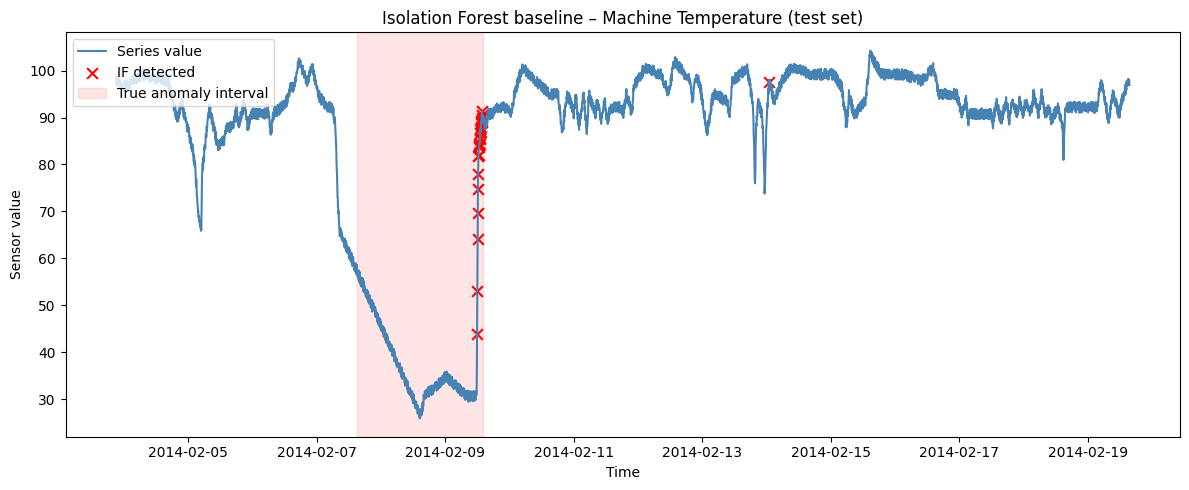

In [11]:
# Visual check of IF baseline on the same representative series
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors   # ensure mpl.colors is loaded

rep_series = "machine_temperature_system_failure"

# Re-compute rolling-stat features on **test** data
test_df   = test_dfs[rep_series]
feat_test = pd.concat(
    [test_df['value'].rolling(ROLL).mean(),
     test_df['value'].rolling(ROLL).std()],
    axis=1
).dropna()
feat_test.columns = ['mean','std']

# Re-fit IF only for plotting (cheap) – or reuse the fitted 'iso' by keeping a dict
iso_plot = IsolationForest(
    n_estimators=200, contamination=IF_CONT, random_state=RSEED
).fit(make_feat(train_dfs[rep_series]))

scores   = -iso_plot.decision_function(feat_test)
thresh   = np.percentile(-iso_plot.decision_function(make_feat(train_dfs[rep_series])), 99)
anoms_ix = feat_test.index[scores > thresh]

# --- plot ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(test_df.index, test_df['value'],  color='steelblue', label='Series value')

# mark anomalies
ax.scatter(anoms_ix, test_df.loc[anoms_ix, 'value'],
           color='red', marker='x', s=60, label='IF detected')

# shade true anomaly intervals
filepath  = series_files[rep_series]
label_key = f"{filepath.parent.name}/{filepath.name}"

test_start = test_df.index[0]
test_end   = test_df.index[-1]

intervals = label_windows.get(label_key, [])
first = True
for start, end in intervals:
    start = pd.to_datetime(start)
    end   = pd.to_datetime(end)
    # Only draw interval if it overlaps the test range
    if end < test_start or start > test_end:
        continue
    # Clamp to test period
    start_clamped = max(start, test_start)
    end_clamped   = min(end, test_end)
    ax.axvspan(start_clamped, end_clamped,
               color='red', alpha=0.1,
               label='True anomaly interval' if first else None)
    first = False


ax.set_title("Isolation Forest baseline – Machine Temperature (test set)")
ax.set_xlabel("Time");  ax.set_ylabel("Sensor value")
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


### 📉 Example: Isolation Forest detections – `machine_temperature_system_failure`

This plot shows the Isolation Forest result on the test portion of the machine temperature series.

- The **blue line** is the sensor value.
- The **red shaded region** is the ground truth anomaly interval.
- The **red "X" markers** show the detected anomaly points.

We observe that:
- Several points *after* the temperature drop are detected.
- The model shows some sensitivity to the post-anomaly shape.
- However, many true anomaly points are missed, explaining the low recall for this series.
---